Epoch 0, Loss: 1.0122791528701782
Epoch 1, Loss: 0.9669049978256226
Epoch 2, Loss: 0.9243249297142029
Epoch 3, Loss: 0.883720874786377
Epoch 4, Loss: 0.8470484018325806
Epoch 5, Loss: 0.8135967254638672
Epoch 6, Loss: 0.7818791270256042
Epoch 7, Loss: 0.7504491209983826
Epoch 8, Loss: 0.7203006744384766
Epoch 9, Loss: 0.6954235434532166
Epoch 10, Loss: 0.6675735116004944
Epoch 11, Loss: 0.6449021100997925
Epoch 12, Loss: 0.6248739361763
Epoch 13, Loss: 0.599655032157898
Epoch 14, Loss: 0.5783738493919373
Epoch 15, Loss: 0.5576354265213013
Epoch 16, Loss: 0.532946765422821
Epoch 17, Loss: 0.518125593662262
Epoch 18, Loss: 0.49762141704559326
Epoch 19, Loss: 0.4847485423088074
Epoch 20, Loss: 0.46325162053108215
Epoch 21, Loss: 0.44856002926826477
Epoch 22, Loss: 0.4322519600391388
Epoch 23, Loss: 0.41168081760406494
Epoch 24, Loss: 0.39863669872283936
Epoch 25, Loss: 0.37863901257514954
Epoch 26, Loss: 0.36482059955596924
Epoch 27, Loss: 0.3510426878929138
Epoch 28, Loss: 0.341083854436

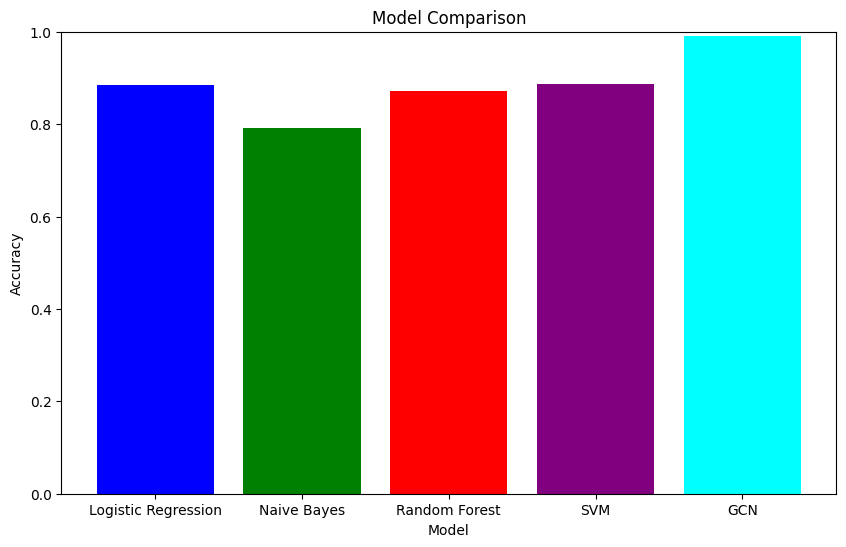

Tweet class: Abusive


In [10]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

# Load and preprocess data
data = pd.read_csv('C:/Users/gangi/OneDrive/Desktop/DL/HateSpeechData.csv')

def simple_preprocess_tweet(tweet):
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = re.sub(r"[^a-zA-Z0-9\s]", "", tweet)
    tweet = tweet.lower()
    tokens = tweet.split()
    stop_words = set(["a", "an", "the", "and", "or", "but", "if", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

data['cleaned_tweet'] = data['tweet'].apply(simple_preprocess_tweet)

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(data['cleaned_tweet'])

# Compute cosine similarity between tweets
cosine_sim = cosine_similarity(tfidf_matrix)
threshold = 0.5
edges = np.argwhere(cosine_sim > threshold)
edges = edges[edges[:, 0] != edges[:, 1]]

x = coo_matrix(tfidf_matrix, dtype=np.float32)
y = torch.tensor(data['class'].values, dtype=torch.long)

num_nodes = x.shape[0]
adj = torch.zeros((num_nodes, num_nodes), dtype=torch.float)
for edge in edges:
    adj[edge[0], edge[1]] = 1
    adj[edge[1], edge[0]] = 1
adj += torch.eye(num_nodes)

# Convert x to sparse tensor
x_indices = torch.tensor([x.row, x.col], dtype=torch.long)
x_values = torch.tensor(x.data, dtype=torch.float32)
x = torch.sparse.FloatTensor(x_indices, x_values, torch.Size(x.shape))

class GraphConvLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        x = self.linear(x)
        x = torch.sparse.mm(adj, x)
        return x

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GraphConvLayer(input_dim, hidden_dim)
        self.conv2 = GraphConvLayer(hidden_dim, output_dim)

    def forward(self, x, adj):
        x = F.relu(self.conv1(x, adj))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, adj)
        return F.log_softmax(x, dim=1)

model = GCN(input_dim=x.shape[1], hidden_dim=16, output_dim=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(x, adj)
    loss = F.nll_loss(out, y)
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(200):
    loss = train()
    print(f'Epoch {epoch}, Loss: {loss}')

def evaluate():
    model.eval()
    _, pred = model(x, adj).max(dim=1)
    correct = int(pred.eq(y).sum().item())
    acc = correct / len(y)
    return acc

gcn_accuracy = evaluate()
print(f'GCN Accuracy: {gcn_accuracy}')

# Splitting the dataset for other models
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, data['class'], test_size=0.2, random_state=42)

# Machine Learning Models
def train_ml_models():
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Naive Bayes': MultinomialNB(),
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC()
    }
    
    accuracies = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        accuracies[name] = accuracy
        print(f'{name} Accuracy: {accuracy}')
    
    return accuracies

ml_accuracies = train_ml_models()

# Comparison Graph
model_names = list(ml_accuracies.keys()) + ['GCN']
model_accuracies = list(ml_accuracies.values()) + [gcn_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(model_names, model_accuracies, color=['blue', 'green', 'red', 'purple', 'cyan'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0, 1)
plt.show()

# Function to detect abusive content
def detect_abusive_content(tweet):
    cleaned_tweet = simple_preprocess_tweet(tweet)
    tweet_tfidf = vectorizer.transform([cleaned_tweet]).toarray()
    tweet_tensor = coo_matrix(tweet_tfidf, dtype=np.float32)
    
    # Convert tweet_tensor to sparse tensor
    tweet_indices = torch.tensor([tweet_tensor.row, tweet_tensor.col], dtype=torch.long)
    tweet_values = torch.tensor(tweet_tensor.data, dtype=torch.float32)
    tweet_tensor = torch.sparse.FloatTensor(tweet_indices, tweet_values, torch.Size(tweet_tensor.shape))
    
    # Creating an adjacency matrix for the new tweet
    num_nodes = tweet_tensor.shape[0]
    adj_temp = torch.zeros((num_nodes, num_nodes), dtype=torch.float)
    adj_temp += torch.eye(num_nodes)
    
    model.eval()
    with torch.no_grad():
        out = model(tweet_tensor, adj_temp)
        _, pred = out.max(dim=1)
        return pred.item()

# Example usage
user_tweet = input("Enter a tweet to classify: ")
result = detect_abusive_content(user_tweet)

# Mapping class label to human-readable output
class_mapping = {
    0: 'Non-Abusive',
    1: 'Abusive',
    2: 'Neutral'  # Adjust based on your actual class labels
}

print("Tweet class:", class_mapping.get(result, "Unknown"))
